# Localization by particle filter

This notebook implements an agent that walk around in a maze randomly and tries to find out its location using the particle filter. 

The agent performs the task under the assumptions listed below:

* Agent has:
    - Complete map of the environment
    - Observation model $P(o_t|\bar{s}_t^{(i)})$ (which corresponds to the 
Subjective probability of the location that the agent can calculate given a particle $\bar{s}_t^{(i)}$)
    - State transition model $P(s_t|s_{t-1}, a_{t-1})$ (which is the probability that the state changes form $s_{t-1}$ to $s_t$ if the agent take action $a_{t-1}$)

The algorithms of the particle filter described below:
- Initialize particle distribution. $t = 1$
- Repeat the following:
 
    1. Sample particle $s_{t-1}^i$ $(1 \leq i \leq N)$ according to the agent behavior $a_{t-1}$ and the state transition probability: $\bar{s}_t^{(i)} \sim P(s_t|s_{t-1}=s_{t-1}^i, a_{t-1})$
    2. Observe $o_t$ and calculate each particle's weight $w_i = P(o_t|\bar{s}_t^{(i)})$
    3. Resample particles according to the weight $w_i / \sum_j w_j$. The new particles are denoted as $s_t^{(k)}$ $1\leq k \leq N$. $s_t^{(k)} \sim \sum_i w_i \delta (s_t, \bar{s}_t^{(i)})$
    4. $t += 1$

I have used Python 3.6.5, Jupyter 4.4.0 for this analysis.

Also, you need the following libraries.

In [1]:
import numpy as np
import os, sys
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=2)
sns.set_style("white")
%matplotlib inline

In [2]:
maze_size = 3
min_val, max_val, diff = 0, 3, 1

In [3]:
prob = np.random.random(9).reshape(3, 3)

In [4]:
def draw_maze(ax, prob, colorbar=True, animated=False, position=None):
    cf = ax.imshow(prob, cmap="viridis", alpha=0.5, vmin=0, vmax=1, animated=animated) 
    if colorbar:
        fig.colorbar(cf, ax=ax)
    ind_array = np.arange(min_val, max_val, diff)
    x, y = np.meshgrid(ind_array, ind_array)
    position_dict = {}
    for idx, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
        c = "S" + str(idx)
        position_dict[c] = (x_val, y_val)
        ax.text(x_val, y_val, c, va='center', ha='center', size=15)
    # Walls of the maze
    ax.plot([0.5, 0.5], [1.5, 2.5], color='red', linewidth=4)
    ax.plot([0.5, 1.5], [0.5, 0.5], color='red', linewidth=4)
    ax.plot([1.5, 1.5], [0.5, 1.5], color='red', linewidth=4)
    ax.plot([1.5, 2.5], [1.5, 1.5], color='red', linewidth=4)
    ax.set_xticks([]);  ax.set_yticks([]);
    if position is not None:
        (x_val, y_val) = position_dict["S"+str(position)]
        ax.plot([x_val], [y_val], marker="o", color="g", markersize=60)
    return cf, position_dict

In this simulation, I have used the maze visualized below. Red lines show walls that the agent cannot pass through.

Original maze code is retrieved from [here](https://github.com/YutaroOgawa/Deep-Reinforcement-Learning-Book/blob/master/program/2_2_maze_random.ipynb).

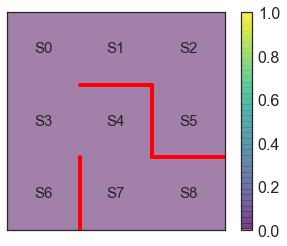

In [20]:
fig, ax = plt.subplots()
_, position_dict = draw_maze(ax, np.zeros((3, 3)))

In [6]:
# Which direction the agent can move
theta = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7
                    [np.nan, np.nan, np.nan, 1]  # s8
                    ])

In [7]:
def simple_convert_into_pi_from_theta(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

In [13]:
def get_next_a(pi, s):
    direction = ["up", "right", "down", "left"]
    next_direction = np.random.choice(direction, p=pi[s, :])
    return next_direction
    
def get_next_a_and_s(pi, s):
    """
    Note that the state s is not observable (The agent cannot use s directory).
    """
    direction = ["up", "right", "down", "left"]
    next_direction = np.random.choice(direction, p=pi[s, :])    
    if next_direction == "up":
        s_next = s - 3 
    elif next_direction == "right":
        s_next = s + 1 
    elif next_direction == "down":
        s_next = s + 3 
    elif next_direction == "left":
        s_next = s - 1 
    return next_direction, s_next

pi = simple_convert_into_pi_from_theta(theta)

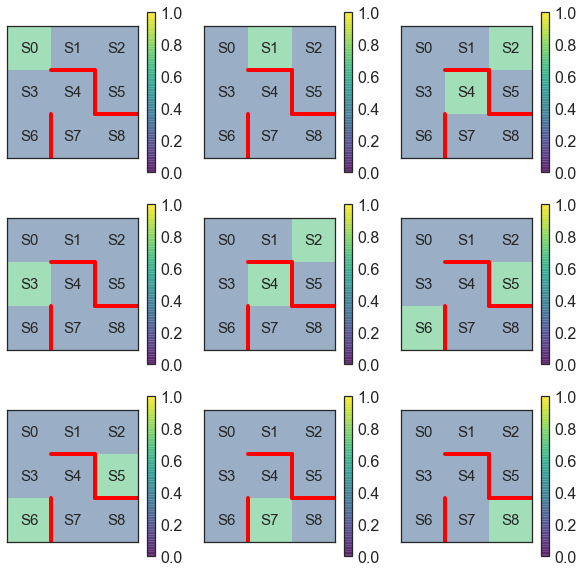

In [43]:
# Observation model
# subjective probability that the agent is in each state given specific (true/estimated) state
observations = np.array([
    # s0: Agent can move right, down
    [[0.7, 0.3, 0.3],
     [0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3],
    ],
    # s1: Agent can move left, right    
    [[0.3, 0.7, 0.3],
     [0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3],
    ],
    # s2: Agent can move left, down same as s4
    [[0.3, 0.3, 0.7],
     [0.3, 0.7, 0.3],
     [0.3, 0.3, 0.3],
    ],
    # s3: Agent can move top, right, down
    [[0.3, 0.3, 0.3],
     [0.7, 0.3, 0.3],
     [0.3, 0.3, 0.3],
    ],
    # s4: Agent can move left, down same as s2
    [[0.3, 0.3, 0.7],
     [0.3, 0.7, 0.3],
     [0.3, 0.3, 0.3],
    ],
    # s5: Agent can move top same as s6
    [[0.3, 0.3, 0.3],
     [0.3, 0.3, 0.7],
     [0.7, 0.3, 0.3],
    ],
    # s6: Agent can move top same as s5
    [[0.3, 0.3, 0.3],
     [0.3, 0.3, 0.7],
     [0.7, 0.3, 0.3],
    ],    
    # s7: Agent can move top, right
    [[0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3],
     [0.3, 0.7, 0.3],
    ],
    # s8: Agent can move left
    [[0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3],
     [0.3, 0.3, 0.7],
    ],
])

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for observation, ax in zip(observations, axes.flatten()):
    draw_maze(ax, observation)

In [44]:
def is_movable(state, action, theta):
    if np.isnan(theta[state, action]):
        return 0
    else:
        return 1

In [45]:
# State transition probabilities
def eval_state_transition_prob(state, action, theta):
    movable_directions = np.array([
        is_movable(state, 0, theta),
        is_movable(state, 1, theta),
        is_movable(state, 2, theta),
        is_movable(state, 3, theta)
    ], dtype=np.float)
    if action == "up":
        a = 0
    elif action == "right":
        a = 1
    elif action == "down":
        a = 2
    else:
        a = 3
    if is_movable(state, a, theta):
        movable_directions[a] *= 0.7
        movable_directions[
            np.arange(len(movable_directions))!=a
        ] *= 0.02 
    else:
        movable_directions[:] *= 0.02
    p = np.zeros(4)
    denom = np.nansum(movable_directions)
    for i in range(4):
        p[i] = movable_directions[i] / denom  # 割合の計算
    p = np.nan_to_num(p)  # nanを0に変換
    return p

# Particle filter

In [46]:
def eval_state_prob(particles):
    """
    Calculate the probability that the agent at each state with particles
    """
    prob_state = np.zeros_like(particles[0])
    for particle in particles:
        prob_state += particle
    return prob_state / len(particles)

In below illustration, green circle shows the agent current location and the color-coded value shows the estimation of the agent's location.

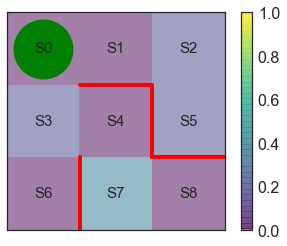

<Figure size 432x288 with 0 Axes>

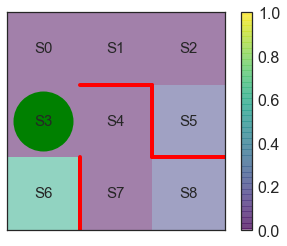

<Figure size 432x288 with 0 Axes>

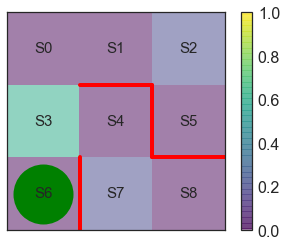

<Figure size 432x288 with 0 Axes>

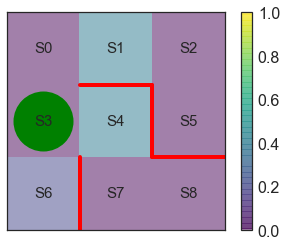

<Figure size 432x288 with 0 Axes>

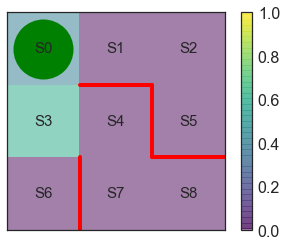

<Figure size 432x288 with 0 Axes>

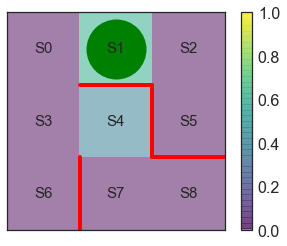

<Figure size 432x288 with 0 Axes>

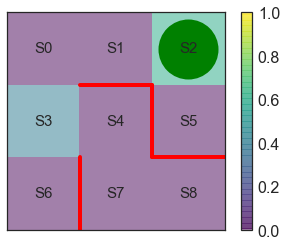

<Figure size 432x288 with 0 Axes>

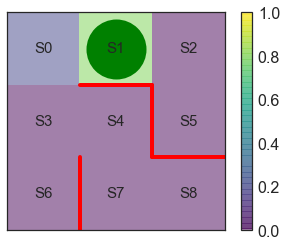

<Figure size 432x288 with 0 Axes>

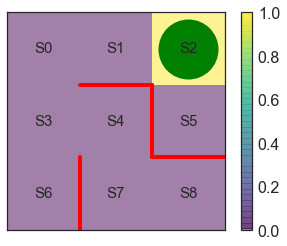

<Figure size 432x288 with 0 Axes>

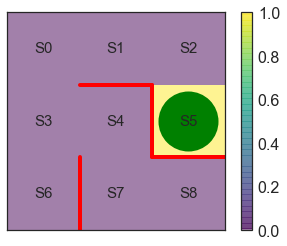

<Figure size 432x288 with 0 Axes>

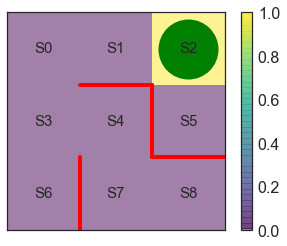

<Figure size 432x288 with 0 Axes>

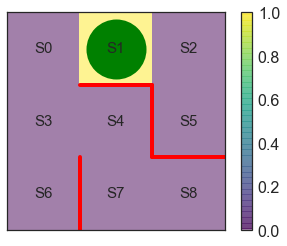

<Figure size 432x288 with 0 Axes>

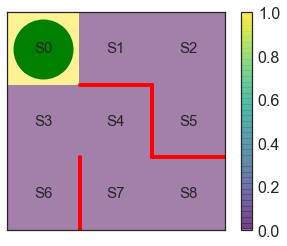

<Figure size 432x288 with 0 Axes>

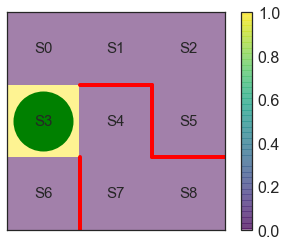

<Figure size 432x288 with 0 Axes>

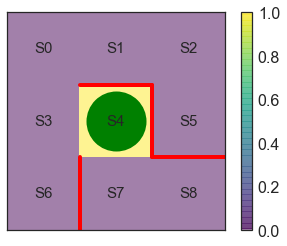

<Figure size 432x288 with 0 Axes>

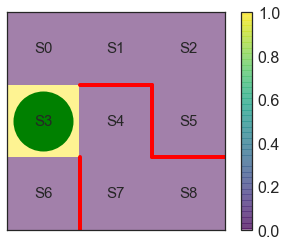

<Figure size 432x288 with 0 Axes>

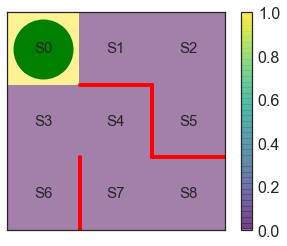

<Figure size 432x288 with 0 Axes>

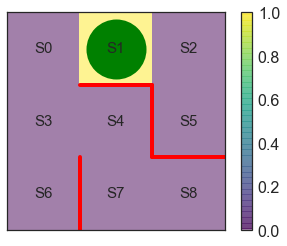

<Figure size 432x288 with 0 Axes>

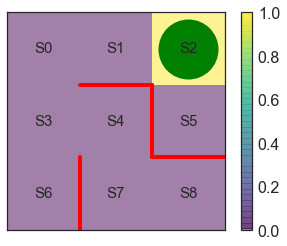

<Figure size 432x288 with 0 Axes>

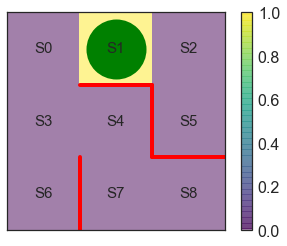

<Figure size 432x288 with 0 Axes>

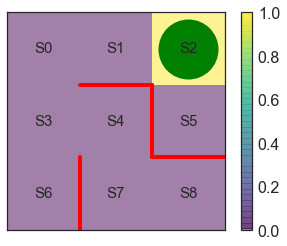

<Figure size 432x288 with 0 Axes>

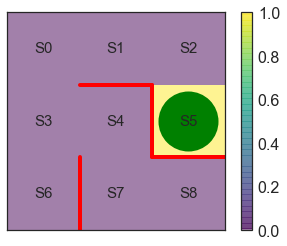

<Figure size 432x288 with 0 Axes>

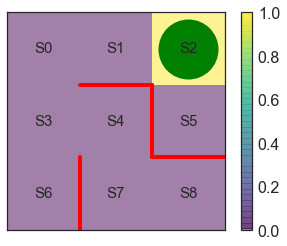

<Figure size 432x288 with 0 Axes>

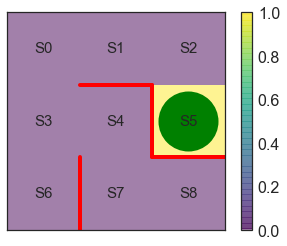

<Figure size 432x288 with 0 Axes>

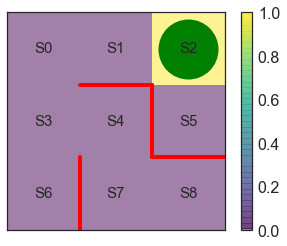

<Figure size 432x288 with 0 Axes>

In [48]:
nparticle = 5
niter = 25
# Initialize particle
particles = []
for _ in range(nparticle):
    particle = np.zeros((maze_size, maze_size))
    particle[
        np.random.randint(low=0, high=maze_size),
        np.random.randint(low=0, high=maze_size)
    ] = 1
    particles.append(particle)
true_state = 0
# (x_val, y_val) = position_dict["S"+str(true_state)]
# fig, ax = plt.subplots()
# im, _ = draw_maze(ax, eval_state_prob(particles), colorbar=False, animated=False)
# line, = ax.plot([x_val], [y_val], marker="o", color="g", markersize=60)
for _ in range(niter):
    action, next_true_state = get_next_a_and_s(pi, true_state)
    (x_val, y_val) = position_dict["S"+str(true_state)]
    fig, ax = plt.subplots()
    ax.plot([x_val], [y_val], marker="o", color="g", markersize=60)
#     line.set_data(x_val, y_val)
#     im.set_array(eval_state_prob(particles))
    im, _ = draw_maze(ax, eval_state_prob(particles), colorbar=True, animated=False)
    #im = ax.plot([x_val], [y_val], marker="o", color="g", markersize=60)
#     ims.append([copy.fro(im)])
    plt.show()
    plt.clf()    
    next_particles = []
    for particle in particles:
        state = np.where(particle.flatten() == 1)[0][0]
        transition_probs = eval_state_transition_prob(state, action, theta)
        estimated_next_move = np.random.choice([0, 1, 2, 3], p=transition_probs)
        if estimated_next_move == 0: # Up
            s_next = state - 3
        elif estimated_next_move == 1: # Right
            s_next = state + 1
        elif estimated_next_move == 2: # Down
            s_next = state + 3
        elif estimated_next_move == 3: # Left
            s_next = state - 1
        particle_next = np.zeros_like(particle).flatten()
        particle_next[s_next] = 1
        particle_next = particle_next.reshape(particle.shape)
        next_particles.append(particle_next)
    # Calculate weights of each particle
    ot = observations[next_true_state]
    weights = np.array([np.sum(ot*particle) for particle in next_particles])        
    resample_dist = np.zeros_like(next_particles[0])
    for weight, particle in zip(weights, next_particles):
        resample_dist += (weight * particle)
    resample_dist /= np.sum(resample_dist)    
    resampled = np.random.choice(
        np.arange(len(resample_dist.flatten())),
        p=resample_dist.flatten(),
        size=nparticle,
        replace=True
    )
    resampled_particles = []
    for rs in resampled:
        particle = np.zeros_like(next_particles[0]).flatten()
        particle[rs] = 1
        resampled_particles.append(particle.reshape(next_particles[0].shape))    
    particles = resampled_particles
    true_state = next_true_state